<a href="https://colab.research.google.com/github/praveenkumarbalakrishnan/tasks/blob/main/SIG731_Data_Wrangling_Task8HD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Title:** Task 8HD: SIG731-Data Wrangling

**Name:** Praveenkumar Balakrishnan

**Student Number:** 223029369

**Email Address:** s223029369@deakin.edu.au


# Import statements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import argparse
import re
import os
import time
import xml.etree.cElementTree as cetree

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Tasks

Selected Movies & TV dataset for this analysis

**Task 1**

Convert all the data tables (Badges, Comments, PostHistory, PostLinks, Posts, Tags, Users, Votes)
from XML to CSV, using custom code that you write yourself. Ideally, you should write a Python
function that takes a single input file name (.xml) and output file name (.csv) and performs the
conversion of a single dataset.

**Task 2**

Load the CSV files as pandas data frames


Column names for 8 dataset based on the schema documentation

In [3]:
file_path = '/content/drive/MyDrive/Inputs/'

badges_cols = ['Id', 'UserId', 'Name', 'Date', 'Class', 'TagBased']
comments_cols = [
    'Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserDisplayName',
    'UserId', 'ContentLicense']
post_history_cols = [
    'Id', 'PostHistoryTypeId', 'PostId', 'RevisionGUID', 'CreationDate',
    'UserId', 'UserDisplayName', 'Comment', 'Text', 'ContentLicense']
post_links_cols = [
    'Id', 'CreationDate', 'PostId', 'RelatedPostId', 'LinkTypeId']
posts_cols = [
    'Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
    'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
    'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
    'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
    'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
    'ContentLicense']
tags_cols = [
    'Id', 'TagName', 'Count', 'ExcerptPostId', 'WikiPostId',
    'IsModeratorOnly', 'IsRequired']
users_cols = [
    'Id', 'Reputation', 'CreationDate', 'DisplayName', 'LastAccessDate',
    'WebsiteUrl', 'Location', 'AboutMe', 'Views', 'UpVotes', 'DownVotes',
    'ProfileImageUrl', 'AccountId']
votes_cols = [
    'Id', 'PostId', 'VoteTypeId', 'UserId',  'CreationDate', 'BountyAmount']

meta_dict = {
    'Badges': badges_cols, 'Comments': comments_cols,
    'PostHistory': post_history_cols, 'PostLinks': post_links_cols,
    'Posts': posts_cols, 'Tags': tags_cols, 'Users': users_cols,
    'Votes': votes_cols}

Parsed the xml elements, iterated in a loop and applied the regex functions to remove extra tags and other characters then load it in a csv file

In [4]:
def get_data(xml_file_name, cols_list):
    """
    This generator is to parse the xml data and yield as a row

    Parameters
    ----------
    file_name: str
      Input xml file name
    cols: list
      Column names of the input files
    
    Yield
    ------
    row: str
      Row from xml data
    """
    col_names = ''
    for col in cols_list:
      col_names = col_names + col + '|'
    col_names = col_names[:-1] + '\n'
    yield col_names

    for event, elem in cetree.iterparse(xml_file_name):
      row = ''
      if elem.tag == "row":
        for col in cols_list:
          if col in elem.attrib:
              val = elem.attrib[col].replace("|", " ").replace('\n', ' ')
              if col in ['Tags']:
                val = re.sub(r'<', '', val)
                val = re.sub(r'>', ' ', val)
              else:
                val = re.sub(r'<.?>', '', val)
                val = re.sub('[^A-Za-z0-9-:.]+', ' ', val)
                val = re.sub(' +', ' ', val)
              row = row + val.rstrip(' p') + '|'
          else:
              row = row + '|'
        row = row[:-1] + '\n'
        yield row
        elem.clear()

def convert_xml_to_csv(file_name, cols_list, path):
  """
  This function is to convert xml to csv and write as csv file
  and upper value

  Parameters
  ----------
  file_name: str
    Input filename without the extension like ".xml"
  cols: list
    Column names of the input files
  
  Return
  ------
  csv_filename: str
    Output csv filename
  """
  xml_file_name = os.path.join(path, file_name + '.xml')
  output_file_name = os.path.join(path, file_name + '.csv')

  data = get_data(xml_file_name, cols_list)
  with open(output_file_name, 'w') as f:
      for item in data:
          f.write(item)
  return output_file_name

Invoked xml conversion function and got the filename then used pandas read_csv to load the data into separate dataframes.

Note: Used dictionary to store the dataframe in the loop

In [5]:
data_dict = {}
for k, v in meta_dict.items():
  csv_file_name = convert_xml_to_csv(k, v, file_path)
  data_dict[k] = pd.read_csv(csv_file_name, delimiter='|')

Loaded as pandas dataframe for the further analysis

In [6]:
badges_df = data_dict['Badges']
comments_df = data_dict['Comments']
post_history_df = data_dict['PostHistory']
post_links_df = data_dict['PostLinks']
posts_df = data_dict['Posts']
tags_df = data_dict['Tags']
users_df = data_dict['Users']
votes_df = data_dict['Votes']

**Task 3**

Create at least five nontrivial data visualisations and/or tables, at least three of which are based
on the extraction of information from text (e.g., tags, keywords, locations, etc.).

**Wordcloud to view most used words in the post title**

movie, character, scene, film, end, know..... are more frequently used and these are so relevant to the movies and tv posts

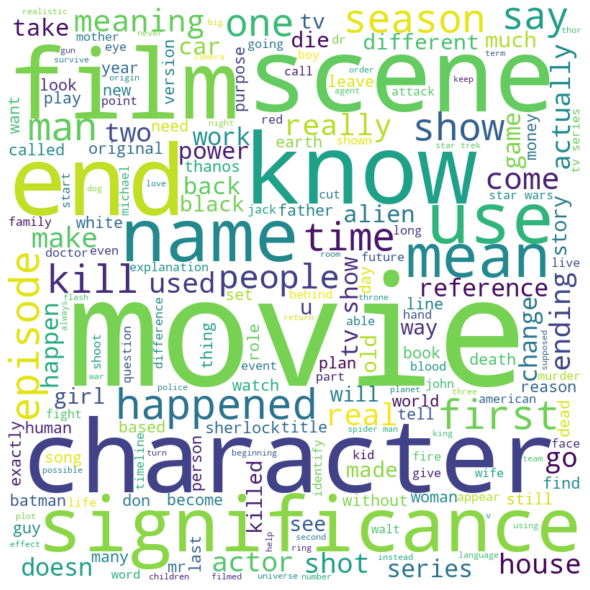

In [7]:
wc_df = posts_df.dropna(subset=['Title']) 
stopwords = set(list(STOPWORDS) + ['s', 'didn', 't'])
words = ' '.join(wc_df['Title'].astype(str)).lower()
wordcloud = WordCloud(
    stopwords=stopwords, min_font_size=10, background_color='white',
    width=800, height=800).generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Cleaning the data to plot country wise users count**

Considered locations with user count more than 10 and cleaned the locations to plot them. 

Note: As we are interested to see which country has more users

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['name'] = world['name'].str.upper()

In [9]:
user_location_cnt_map = users_df['Location'].dropna().value_counts()[
    users_df['Location'].value_counts().dropna() > 10].to_dict()

In [10]:
cleaned_user_location_cnt_map = {}
for k, v in user_location_cnt_map.items():
  val = k.split(' ')[-1]
  if val in [
      'States', 'USA', 'California', 'CA', 'WA', 'IL', 'Texas', 'NY',
       'MA', 'TX', 'PA', 'GA', 'OR', 'York', 'Jersey', 'CO', 'Florida',
       'Utah', 'Michigan', 'MN', 'FL', 'Ohio', 'Massachusetts', 'Maryland',
       'Connecticut', 'Minnesota', 'OH', 'Carolina', 'DC', 'Francisco',
       'US', 'NC', 'MD', 'Virginia', 'Pennsylvania', 'Illinois', 'Arizona',
       'AZ', 'MO', 'Colorado', 'Oregon', 'Wisconsin', 'NYC', 'WI', 'Kansas',
       'Iowa', 'Indiana']:
    val = "United States of America"
  elif val in ['Kingdom', 'UK', 'England', 'London', 'Scotland']:
    val = "United Kingdom"
  elif val in [
      'Bangalore', 'Delhi', 'Pune', 'Chennai', 'Hyderabad', 'Ahmedabad',
      'Mumbai']:
    val = 'India'
  elif val in ['Zealand']:
    val = 'New Zealand'
  elif val in ['Lanka']:
    val = 'Sri Lanka'
  elif val in ['Emirates']:
    val = 'United Arab Emirates'
  elif val in ['Brasil']:
    val = 'Brazil'
  elif val in ['Paris']:
    val = 'France'
  elif val in ['Toronto']:
    val = 'Canada'
  elif val in ['Istanbul']:
    val = 'Turkey'
  elif val in ['Deutschland', 'Berlin']:
    val = 'Germany'
  elif val in ['xico']:
    val = 'Mexico'
  elif val in ['Republic', 'Prague']:
    val = 'Czechia'
  else:
    val = val
  if val.upper() in cleaned_user_location_cnt_map:
    v += cleaned_user_location_cnt_map[val.upper()]
  names = [col.lower() for col in world['name'].to_list()]
  if val.lower() in world['name'].str.lower().to_list():
    cleaned_user_location_cnt_map[val.upper()] = v

In [11]:
country_count_df = pd.DataFrame({
    'name': cleaned_user_location_cnt_map.keys(),
     'value': cleaned_user_location_cnt_map.values()})
world = world.merge(country_count_df, on=['name'], how='left')
world['value'] = world['value'].fillna(0)

No of users from US and India is high compared to other countries

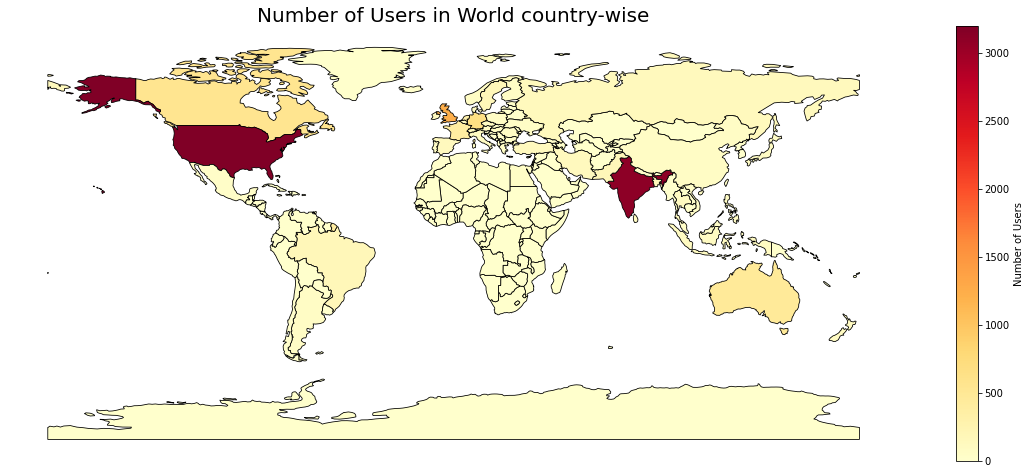

In [12]:
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
ax.set_title(
    'Number of Users in World country-wise',
     fontdict={'fontsize': '20', 'fontweight' : '10'})
# Plot the figure
world.plot(column='value',cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0',
           legend=True, markersize=[39.739192, -104.990337],
           legend_kwds={'label': "Number of Users"})
plt.show()

In [13]:
world.sort_values('value', ascending=False)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,value
4,3.282395e+08,North America,UNITED STATES OF AMERICA,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3199.0
98,1.366418e+09,Asia,INDIA,IND,2868929,"POLYGON ((97.32711 28.26158, 97.40256 27.88254...",3106.0
143,6.683440e+07,Europe,UNITED KINGDOM,GBR,2829108,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",1234.0
121,8.313280e+07,Europe,GERMANY,DEU,3861123,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",665.0
3,3.758926e+07,North America,CANADA,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",558.0
...,...,...,...,...,...,...,...
67,5.380508e+06,Africa,CONGO,COG,12267,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ...",0.0
68,2.172579e+06,Africa,GABON,GAB,16874,"POLYGON ((11.27645 2.26105, 11.75167 2.32676, ...",0.0
69,1.355986e+06,Africa,EQ. GUINEA,GNQ,11026,"POLYGON ((9.64916 2.28387, 11.27645 2.26105, 1...",0.0
70,1.786103e+07,Africa,ZAMBIA,ZMB,23309,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",0.0


**Plot to explore top 10 tags on the post**

In [14]:
tags_count_map = pd.Series(
    ' '.join(posts_df['Tags'].dropna().astype(str)).lower().split()
    ).value_counts()
top_10_tags_count_map = tags_count_map[:10]
top_10_tags_count_map

plot-explanation             8091
character                    2336
analysis                     1366
marvel-cinematic-universe    1322
dialogue                      916
identify-this-movie           861
game-of-thrones               797
production                    682
film-techniques               540
realism                       487
dtype: int64

Plot explanation, character discussion, movie analysis & Marvel Cinematic Universe related to posts are high compared to others

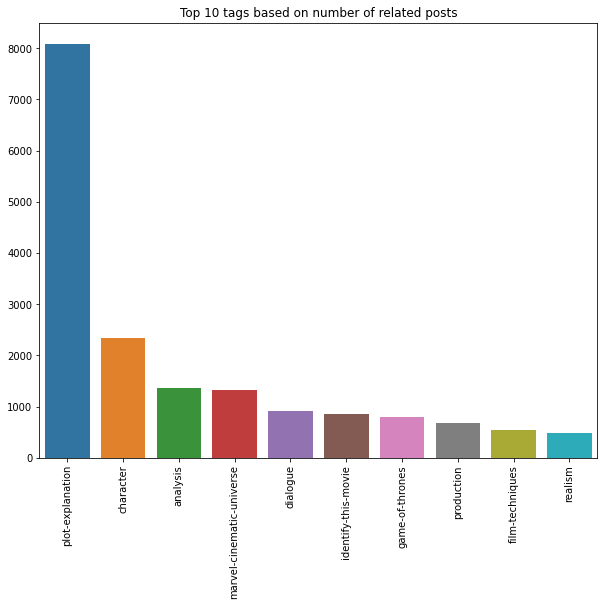

In [15]:
plt.figure(figsize=(10,8))
plt.title("Top 10 tags based on number of related posts")
plot = sns.barplot(
    x=list(top_10_tags_count_map.index), y=top_10_tags_count_map.values)
plt.xticks(rotation=90)
plt.show()


In [16]:
top_10_tags_count_map

plot-explanation             8091
character                    2336
analysis                     1366
marvel-cinematic-universe    1322
dialogue                      916
identify-this-movie           861
game-of-thrones               797
production                    682
film-techniques               540
realism                       487
dtype: int64

**Numerical columns distribution for posts**

All these columns are heavily right skewed, ViewCount is large in scale so after applying log transformation view count is closer to normal distribution with mild skewness

In [17]:
posts_df[['Score', 'ViewCount', 'AnswerCount']].describe().T

,count,mean,std,min,25%,50%,75%,max
Score,62663.0,7.285543,11.751316,-24.0,1.0,4.0,9.0,326.0
ViewCount,22065.0,7540.889735,29029.367814,6.0,402.0,1368.0,4989.0,1522159.0
AnswerCount,22065.0,1.642420,1.447578,0.0,1.0,1.0,2.0,19.0


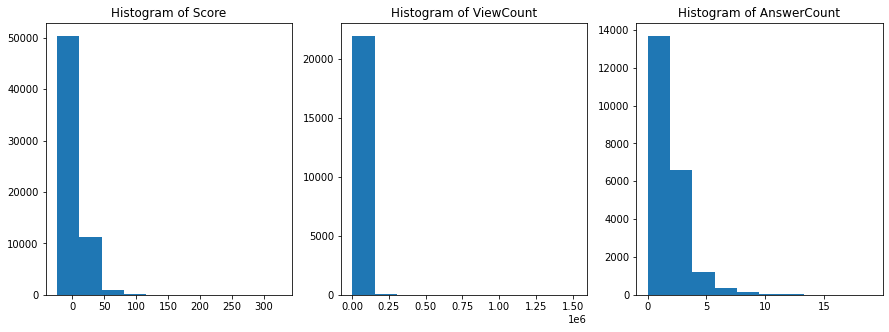

In [18]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Score', 'ViewCount', 'AnswerCount']):
  plt.subplot(1,3,i+1)
  plt.title(f"Histogram of {col}")
  plt.hist(posts_df[col])
plt.show()

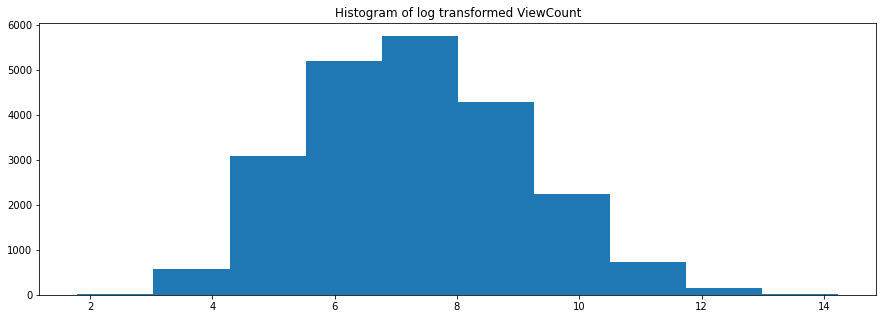

In [19]:
plt.figure(figsize=(15, 5))
plt.title(f"Histogram of log transformed ViewCount")
plt.hist(np.log(posts_df['ViewCount']))
plt.show()

**Plot to display no of related and duplicate posts**

LinkTypeId type of link

1 = Linked (PostId contains a link to RelatedPostId)

3 = Duplicate (PostId is a duplicate of RelatedPostId)

1360 duplicate posts are there in this dataset

In [20]:
pl_df = post_links_df.groupby(
    'LinkTypeId')['Id'].count().reset_index().rename({'Id': 'Count'})

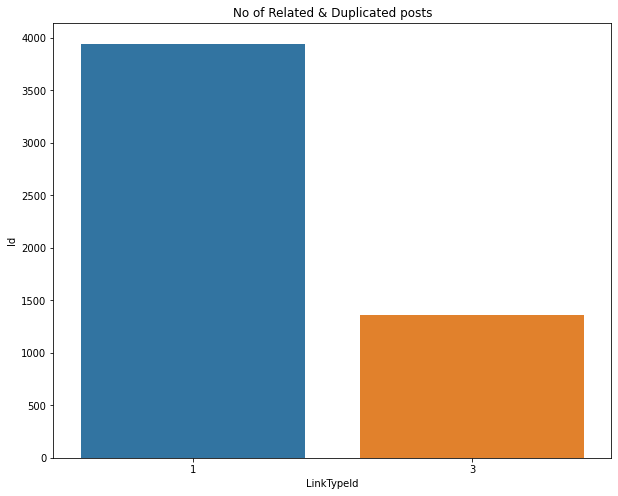

In [21]:
plt.figure(figsize=(10,8))
plt.title("No of Related & Duplicated posts")
plot = sns.barplot(
    x=pl_df['LinkTypeId'], y=pl_df['Id'])
plt.show()

**Task 4**

Draw insightful and interesting conclusions. Do not forget to reflect on the potential data privacy
and ethics issues that arise during the data analysis process.

Most common used words in the posts title is movie, character, scene, film, end and know whis is so relevent to the dataset that we are analysing. No of users from US and India is high compared to the users from other countries. Most common posts are related to plot explanation, character discussion, movie analysis & Marvel Cinematic Universe topics. Score, ViewCount and AnswerCount is heavily right skewed, after applying log transformation on viewcount it is kind of closer to normal distribution. There are 1360 duplicate posts related to the movies & tv datasets.

During data collection an ethical approach to data management is to make it clear to the user on what data is being collected and why, our analysis should stick to that and for different analysis we have to get consent from the user before proceeding. Data should be stored securely with appropriate access for the analysis, sensitive informations like location, image, user post related to specific topic should not be shared publically. Applying the analysis should be ethical like in this analysis when are enhancing some features doing the analysis only for particular group is not ethical unless there is justified ethical reason, ideally everyone should be treated equally so when we apply our analysis we should be careful about that. Having that data encoded to not disclose the respondent actual identity will reduce some of the ethical concern.